# Glider Intercalibration Analysis

This notebook analyzes and visualizes the intercalibration between different gliders by comparing their profiles and calculating various metrics.

In [1]:
import xarray as xr
import polars as pl
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from geopy.distance import geodesic
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## Load and Process Glider Data

In [2]:
# Get list of NetCDF files
nc_files = glob.glob("C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled/*.nc")

# Read and concatenate datasets
for file in nc_files:
    ds = xr.open_dataset(file, decode_times=True)
    glider_name = ds.attrs.get("trajectory").split("_")[0]
    # Select variables of interest
    vars_of_interest = ["TIME", "DEPTH", "TEMP", "CHLA", "BBP700", "ABS_SALINITY", "MOLAR_DOXY", "PROFILE_NUMBER", "LATITUDE", "LONGITUDE"]
    ds_sel = ds[vars_of_interest]
    # Convert to pandas DataFrame, then to polars DataFrame
    df_pd = ds_sel.to_dataframe().reset_index()
    df_pl = pl.from_pandas(df_pd)

    #Use only profiling data (-1 is surfacing behavior)
    df_pl = df_pl.filter(pl.col("PROFILE_NUMBER") > 0)

    df_pl = df_pl.with_columns((pl.col("PROFILE_NUMBER").cast(pl.String) + "_" + glider_name).alias("profile_id"))
    print(f"{file} processed, shape: {df_pl.shape}")

    # Concatenate DataFrames
    if 'df_concat' in locals():
        df_concat = pl.concat([df_concat, df_pl])
    else:
        df_concat = df_pl

# Add a 'glider_name' column
df_concat = df_concat.with_columns(
    pl.col("profile_id").str.split("_").list.get(1).alias("glider_name")
)

C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Cabot_645_Profiled.nc processed, shape: (1438541, 12)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Churchill_647_Profiled.nc processed, shape: (1142019, 12)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Doombar_648_Profiled.nc processed, shape: (1952630, 12)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Nelson_646_Profiled.nc processed, shape: (1951435, 12)


## Create Summary DataFrame for Profile Locations

In [3]:
# Group by 'profile_id' and 'glider_name', then aggregate median datetime, longitude, latitude
summary = (
    df_concat
    .group_by(['profile_id', 'glider_name'])
    .agg([
        pl.col('TIME').median().alias('median_datetime'),
        pl.col('LONGITUDE').median().alias('median_longitude'),
        pl.col('LATITUDE').median().alias('median_latitude')
    ])
    .sort('median_datetime')
)

# Convert to pandas DataFrame
summary_pd = summary.to_pandas()

## 1. Distance Over Time Visualization

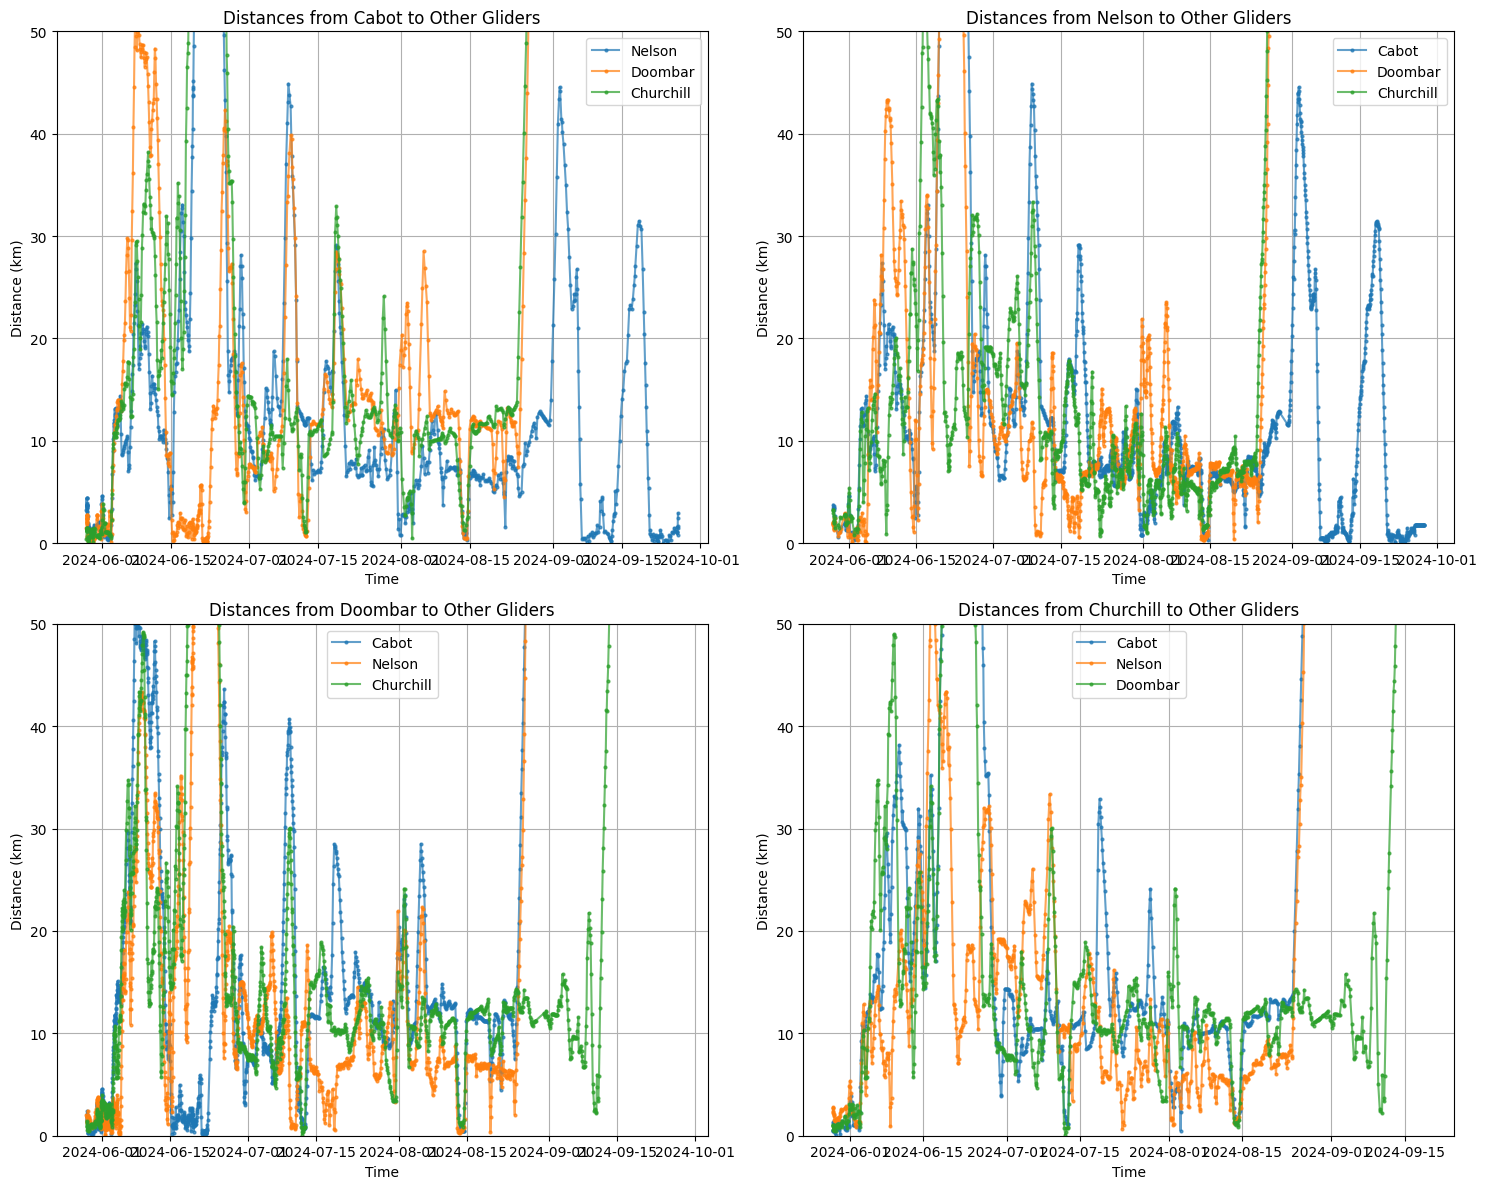

In [6]:
def calculate_distances_to_other_gliders(summary_df, reference_glider):
    # Filter data for the reference glider
    ref_data = summary_df[summary_df['glider_name'] == reference_glider]
    
    # Initialize lists to store results
    distances = {glider: [] for glider in summary_df['glider_name'].unique() if glider != reference_glider}
    times = []
    
    # For each profile of the reference glider
    for _, ref_row in ref_data.iterrows():
        ref_time = ref_row['median_datetime']
        ref_pos = (ref_row['median_latitude'], ref_row['median_longitude'])
        
        # Find closest profile from each other glider within 1 hour
        for other_glider in distances.keys():
            other_data = summary_df[summary_df['glider_name'] == other_glider]
            time_diffs = abs((other_data['median_datetime'] - ref_time).dt.total_seconds())
            valid_profiles = other_data[time_diffs <= 3600]  # Within 1 hour
            
            if not valid_profiles.empty:
                # Calculate distances to all valid profiles
                profile_distances = []
                for _, other_row in valid_profiles.iterrows():
                    other_pos = (other_row['median_latitude'], other_row['median_longitude'])
                    if all(np.isfinite(pos) for pos in other_pos + ref_pos):
                        dist = geodesic(ref_pos, other_pos).km
                        profile_distances.append(dist)
                
                if profile_distances:
                    distances[other_glider].append(min(profile_distances))
                else:
                    distances[other_glider].append(np.nan)
            else:
                distances[other_glider].append(np.nan)
        
        times.append(ref_time)
    
    return pd.DataFrame({'time': times, **distances})

# Create subplots for each glider
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, glider in enumerate(summary_pd['glider_name'].unique()):
    distances_df = calculate_distances_to_other_gliders(summary_pd, glider)
    distances_df.set_index('time', inplace=True)  # Set 'time' column as the index for interpolation
    distances_df.interpolate(method='time', inplace=True)  # Ensure continuous lines by interpolating missing values
    distances_df.reset_index(inplace=True)  # Reset the index back to default after interpolation
    ax = axes[idx]
    for other_glider in distances_df.columns[1:]:
        ax.plot(distances_df['time'], distances_df[other_glider], 
                label=other_glider, marker='o', markersize=2, linestyle='-', alpha=0.7)
    
    ax.set_title(f'Distances from {glider} to Other Gliders')
    ax.set_xlabel('Time')
    ax.set_ylabel('Distance (km)')
    ax.legend()
    ax.grid(True)
    ax.set_ylim(0, 50)  # Adjust y-axis limit as needed

plt.tight_layout()
plt.show()

## 2. Colocated Profiles Heatmap

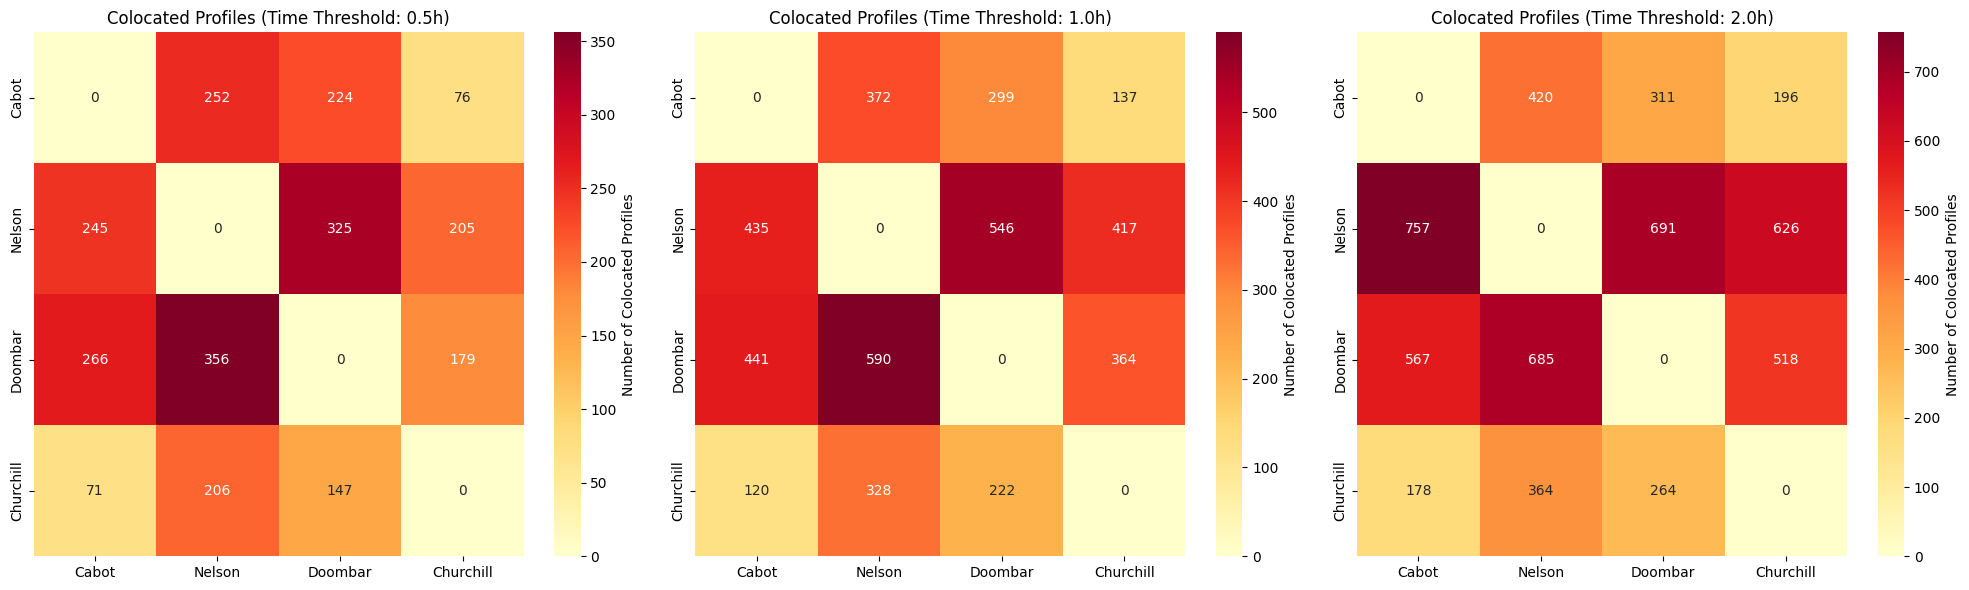

In [7]:
def count_colocated_profiles(summary_df, time_threshold=3600, distance_threshold=10):
    gliders = summary_df['glider_name'].unique()
    n_gliders = len(gliders)
    colocation_matrix = np.zeros((n_gliders, n_gliders))
    
    for i, glider1 in enumerate(gliders):
        for j, glider2 in enumerate(gliders):
            if i != j:
                glider1_data = summary_df[summary_df['glider_name'] == glider1]
                glider2_data = summary_df[summary_df['glider_name'] == glider2]
                
                count = 0
                for _, row1 in glider1_data.iterrows():
                    time_diffs = abs((glider2_data['median_datetime'] - row1['median_datetime']).dt.total_seconds())
                    valid_profiles = glider2_data[time_diffs <= time_threshold]
                    
                    for _, row2 in valid_profiles.iterrows():
                        pos1 = (row1['median_latitude'], row1['median_longitude'])
                        pos2 = (row2['median_latitude'], row2['median_longitude'])
                        if all(np.isfinite(pos) for pos in pos1 + pos2):
                            dist = geodesic(pos1, pos2).km
                            if dist <= distance_threshold:
                                count += 1
                                break
                
                colocation_matrix[i, j] = count
    
    return pd.DataFrame(colocation_matrix, index=gliders, columns=gliders)

# Create heatmaps for different time thresholds
time_thresholds = [1800, 3600, 7200]  # 30min, 1hour, 2hours
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, threshold in enumerate(time_thresholds):
    colocation_matrix = count_colocated_profiles(summary_pd, time_threshold=threshold)
    
    sns.heatmap(colocation_matrix, annot=True, fmt='.0f', cmap='YlOrRd',
                ax=axes[idx], cbar_kws={'label': 'Number of Colocated Profiles'})
    axes[idx].set_title(f'Colocated Profiles (Time Threshold: {threshold/3600:.1f}h)')

plt.tight_layout()
plt.show()

## 3. R² Criteria Analysis

In [6]:
def calculate_r2_criteria(df_concat, summary_df, variables, time_threshold=3600, distance_threshold=10):
    gliders = summary_df['glider_name'].unique()
    n_gliders = len(gliders)
    r2_matrices = {var: np.zeros((n_gliders, n_gliders)) for var in variables}
    
    for i, glider1 in enumerate(gliders):
        for j, glider2 in enumerate(gliders):
            if i != j:
                glider1_data = summary_df[summary_df['glider_name'] == glider1]
                glider2_data = summary_df[summary_df['glider_name'] == glider2]
                
                for _, row1 in glider1_data.iterrows():
                    time_diffs = abs((glider2_data['median_datetime'] - row1['median_datetime']).dt.total_seconds())
                    valid_profiles = glider2_data[time_diffs <= time_threshold]
                    
                    for _, row2 in valid_profiles.iterrows():
                        pos1 = (row1['median_latitude'], row1['median_longitude'])
                        pos2 = (row2['median_latitude'], row2['median_longitude'])
                        if all(np.isfinite(pos) for pos in pos1 + pos2):
                            dist = geodesic(pos1, pos2).km
                            if dist <= distance_threshold:
                                # Get profiles for both gliders
                                profile1 = df_concat.filter(
                                    (pl.col('profile_id') == row1['profile_id']) &
                                    (pl.col('glider_name') == glider1)
                                )
                                profile2 = df_concat.filter(
                                    (pl.col('profile_id') == row2['profile_id']) &
                                    (pl.col('glider_name') == glider2)
                                )
                                
                                # Calculate R² for each variable
                                for var in variables:
                                    if var in profile1.columns and var in profile2.columns:
                                        x = profile1[var].to_numpy()
                                        y = profile2[var].to_numpy()
                                        if len(x) > 0 and len(y) > 0:
                                            r2 = stats.pearsonr(x, y)[0] ** 2
                                            r2_matrices[var][i, j] += r2
    
    return r2_matrices

# Define variables to analyze
variables = ['TEMP', 'CHLA', 'BBP700', 'ABS_SALINITY', 'MOLAR_DOXY']

# Calculate R² matrices
r2_matrices = calculate_r2_criteria(df_concat, summary_pd, variables)

# Plot heatmaps for each variable
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, (var, matrix) in enumerate(r2_matrices.items()):
    if idx < len(axes):
        sns.heatmap(matrix, annot=True, fmt='.2f', cmap='YlOrRd',
                    ax=axes[idx], cbar_kws={'label': 'R²'})
        axes[idx].set_title(f'{var} R² Values')

plt.tight_layout()
plt.show()

ValueError: x and y must have the same length.

## 4. Regression Plots

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 814244 and the array at index 1 has size 550303

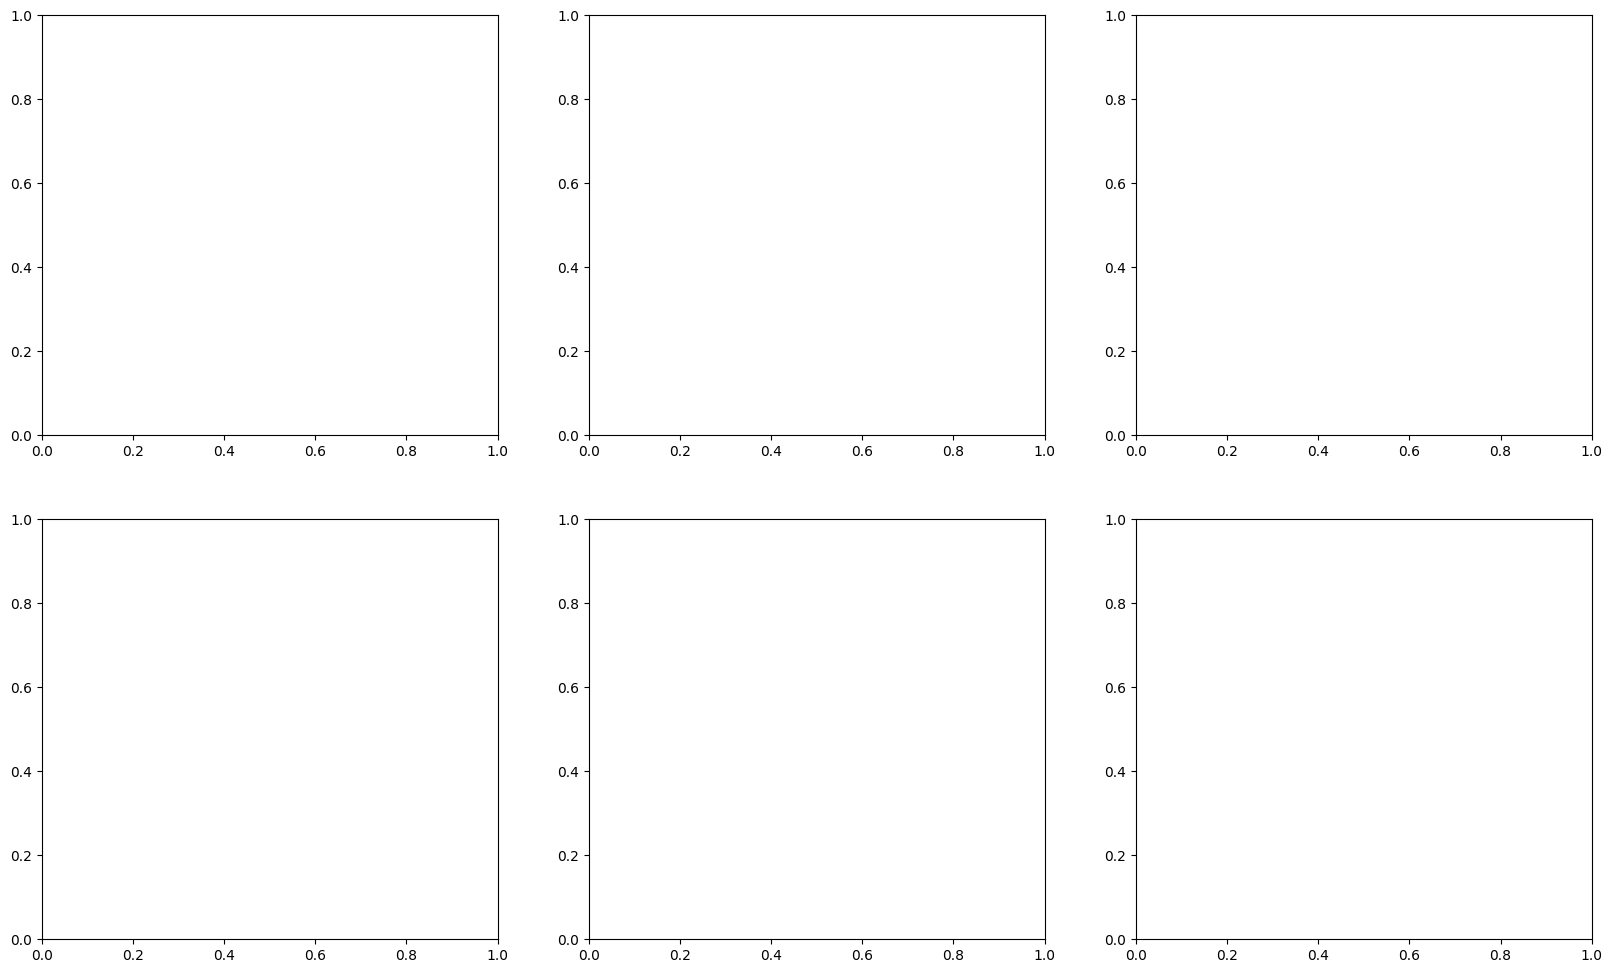

In [7]:
def plot_regression_comparisons(df_concat, summary_df, variables, time_threshold=3600, distance_threshold=10):
    gliders = summary_df['glider_name'].unique()
    n_vars = len(variables)
    
    for i, glider1 in enumerate(gliders):
        for j, glider2 in enumerate(gliders):
            if i < j:  # Only plot each pair once
                fig, axes = plt.subplots(2, 3, figsize=(20, 12))
                axes = axes.flatten()
                
                glider1_data = summary_df[summary_df['glider_name'] == glider1]
                glider2_data = summary_df[summary_df['glider_name'] == glider2]
                
                for var_idx, var in enumerate(variables):
                    if var_idx < len(axes):
                        ax = axes[var_idx]
                        
                        # Collect all matching profile pairs
                        x_values = []
                        y_values = []
                        
                        for _, row1 in glider1_data.iterrows():
                            time_diffs = abs((glider2_data['median_datetime'] - row1['median_datetime']).dt.total_seconds())
                            valid_profiles = glider2_data[time_diffs <= time_threshold]
                            
                            for _, row2 in valid_profiles.iterrows():
                                pos1 = (row1['median_latitude'], row1['median_longitude'])
                                pos2 = (row2['median_latitude'], row2['median_longitude'])
                                if all(np.isfinite(pos) for pos in pos1 + pos2):
                                    dist = geodesic(pos1, pos2).km
                                    if dist <= distance_threshold:
                                        profile1 = df_concat.filter(
                                            (pl.col('profile_id') == row1['profile_id']) &
                                            (pl.col('glider_name') == glider1)
                                        )
                                        profile2 = df_concat.filter(
                                            (pl.col('profile_id') == row2['profile_id']) &
                                            (pl.col('glider_name') == glider2)
                                        )
                                        
                                        if var in profile1.columns and var in profile2.columns:
                                            x = profile1[var].to_numpy()
                                            y = profile2[var].to_numpy()
                                            if len(x) > 0 and len(y) > 0:
                                                x_values.extend(x)
                                                y_values.extend(y)
                        
                        if x_values and y_values:
                            # Calculate regression
                            slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
                            
                            # Plot
                            ax.scatter(x_values, y_values, alpha=0.5, s=10)
                            
                            # Add regression line
                            x_line = np.array([min(x_values), max(x_values)])
                            y_line = slope * x_line + intercept
                            ax.plot(x_line, y_line, 'r-', label=f'y = {slope:.2f}x + {intercept:.2f}')
                            
                            # Add 1:1 line
                            ax.plot(x_line, x_line, 'k--', label='1:1 line')
                            
                            ax.set_xlabel(f'{glider1} {var}')
                            ax.set_ylabel(f'{glider2} {var}')
                            ax.set_title(f'{var} Comparison\nR² = {r_value**2:.3f}')
                            ax.legend()
                            ax.grid(True)
                
                plt.suptitle(f'Regression Analysis: {glider1} vs {glider2}', y=1.02)
                plt.tight_layout()
                plt.show()

# Plot regression comparisons
plot_regression_comparisons(df_concat, summary_pd, variables)